## Prever elegibilidade de empréstimo para uma empresa de financiamento

*O processo funciona da seguinte forma: a empresa recebe a solicitação do cliente para um empréstimo e, busca, validar a sua elegibilidade para o mesmo.*  
 

**O desejo da empresa:** *automatizar o processo de elegibilidade do empréstimo (em tempo real) com base nas informações fornecidas pelo cliente durante o preenchimento do formulário de inscrição online, cujas informações são: gênero, estado civil, educação, número de dependentes, renda, valor do empréstimo, histórico de crédito e outros.* 

*Para automatizar esse processo, temos um conjunto de dados para identificar os segmentos de clientes que são elegíveis para o valor do empréstimo, de forma que possam direcionar especificamente esses clientes.*


* **Importando Bibliotecas**

In [44]:
import pandas as pd
import numpy as np
import sklearn
import lazypredict
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12,8

* **Importando os conjuntos de dados de treino e teste**

In [45]:
train = pd.read_csv('train_ctrUa4K.csv')
test  = pd.read_csv('test_lAUu6dG.csv')

* **Fazendo uma cópia dos conjuntos dados de treino e teste**

In [46]:
train_original = train.copy() 
test_original  = test.copy()

## Análise exploratória de dados

* **Visualizando as primeiras 10 linhas do conjunto de dados de treino**

In [47]:
train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


* **Informações de cada variável do conjunto de dados de treino**

In [48]:
df_aux = pd.DataFrame({'Type': train.dtypes,
                      'Missing': train.isna().sum(),
                      'Size': train.shape[0],
                       'Unique': train.nunique()
                     })
df_aux['Missing_%']= df_aux.Missing/df_aux.Size * 100
df_aux.sort_values(by='Missing_%', ascending=False)

,Type,Missing,Size,Unique,Missing_%
Credit_History,float64,50,614,2,8.143322
Self_Employed,object,32,614,2,5.211726
LoanAmount,float64,22,614,203,3.583062
Dependents,object,15,614,4,2.442997
Loan_Amount_Term,float64,14,614,10,2.280130
Gender,object,13,614,2,2.117264
Married,object,3,614,2,0.488599
Loan_ID,object,0,614,614,0.000000
Education,object,0,614,2,0.000000
ApplicantIncome,int64,0,614,505,0.000000


\begin{array}{cc}
\text{Loan ID} & \text{ID de empréstimo exclusivo}\\
\text{Gender} & \text{Gênero: Masculino e feminino}\\
\text{Married} & \text{Casado (S/N)}\\
\text{Dependents} & \text{Número de dependentes}\\
\text{Education} & \text{Educação do Candidato (Graduação /Não Graduação)}\\
\text{Self Employed} & \text{Autônomo	(S / N)}\\
\text{ApplicantIncome} & \text{ Renda do requerente}\\
\text{CoapplicantIncome} & \text{Renda do co-aplicante }\\
\text{Loan Amount} & \text{Montante do empréstimo }\\
\text{Loan Amount Term} & \text{Prazo do empréstimo em meses}\\
\text{Credit History} & \text{Histórico de crédito	}\\
\text{Property Area} & \text{Área de Propriedade: Urbano / Semi Urbano / Rural }\\
\text{Loan Status} & \text{Status do empréstimo: (Alvo) Empréstimo aprovado (S / N)}
\end{array}

* **Informações de cada variável do conjunto de dados de teste**

In [49]:
df_aux_test = pd.DataFrame({'Type': test.dtypes,
                      'Missing': test.isna().sum(),
                      'Size': test.shape[0],
                       'Unique': test.nunique()
                     })
df_aux_test['Missing_%']= df_aux_test.Missing/df_aux_test.Size * 100
df_aux_test.sort_values(by='Missing_%', ascending=False)

,Type,Missing,Size,Unique,Missing_%
Credit_History,float64,29,367,2,7.901907
Self_Employed,object,23,367,2,6.267030
Gender,object,11,367,2,2.997275
Dependents,object,10,367,4,2.724796
Loan_Amount_Term,float64,6,367,12,1.634877
LoanAmount,float64,5,367,144,1.362398
Loan_ID,object,0,367,367,0.000000
Married,object,0,367,2,0.000000
Education,object,0,367,2,0.000000
ApplicantIncome,int64,0,367,314,0.000000


Temos variáveis:
* **Categóricas nominais:**

Loan_ID, Gender, Married, Self_Employed, Credit_History e Loan_Status. 

* **Categóricas ordinais:**

Dependents, Education e Property_Area. 

* **Numéricas:** 

ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term.

In [50]:
def grafico_com_porcetagem(df,feature):
    total = len(df)
    ax =  sns.countplot(x=feature,data=df,color = "#2b8cbe")
    ax.set_ylim(0,total*1.05) # Ajusta altura do frame
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate('{:.2f}%'.format(100*p.get_height()/total), (x, y+10), ha='center')
    return ax
def grafico_com_porcetagem_1(g):
    g.ax.set_ylim(0,100)
    for p in g.ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        g.ax.annotate('{:.2f}%'.format(p.get_height()), (x, y+2), ha='center')
    return g

* **Visualizando as variáveis independentes  categóricas nominais** 

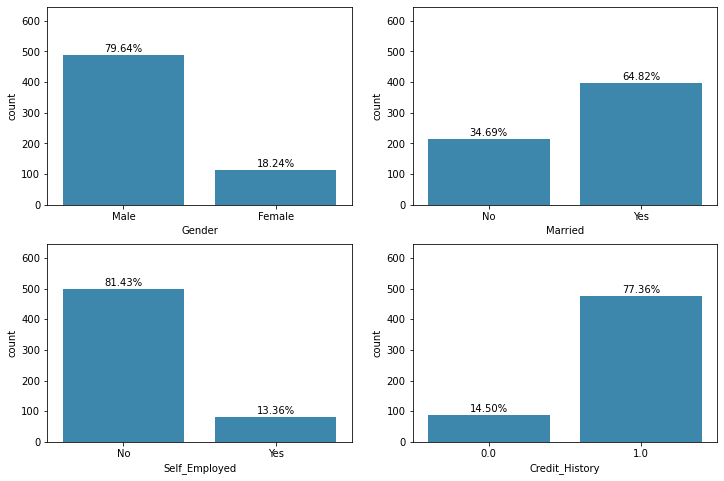

In [51]:
plt.subplot(221),grafico_com_porcetagem(train[['Gender']],'Gender')
plt.subplot(222),grafico_com_porcetagem(train[['Married']],'Married')
plt.subplot(223),grafico_com_porcetagem(train[['Self_Employed']],'Self_Employed')
plt.subplot(224),grafico_com_porcetagem(train[['Credit_History']],'Credit_History')
plt.show()


No conjunto de dados em análise, observamos que:

* Os clientes do sexo masculinos dominam os pedidos de empréstimo. 

* O mesmo é visto para os que são casados e, também os não autônomos.  

* Além disso, os que têm um histórico de crédito positivo são os que mais solicitam empréstimo. 


### Visualizando as variáveis independentes categóricas ordinais

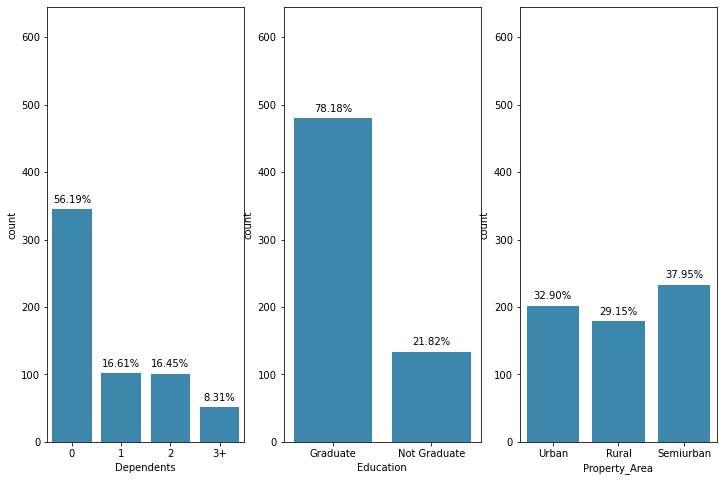

In [52]:
plt.subplot(131),grafico_com_porcetagem(train[['Dependents']],'Dependents')
plt.subplot(132),grafico_com_porcetagem(train[['Education']],'Education')
plt.subplot(133),grafico_com_porcetagem(train[['Property_Area']],'Property_Area')
plt.show()

No conjunto de dados em questão, observamos que:

* Os clientes com zero número de dependentes são os que têm mais interesse pelo  empréstimo. 

* Isso segue para os que possuem graduação. 

* E por fim, podemos ver que os pedidos de empréstimo por Zona (Urbana, Semi Urbana ou  Rural) estão aproximadamente  distribuídos, com uma pequena diferença, dos demais, para os clientes que moram na Zona Semi Urbana. 



* **Analisando o status de empréstimo**

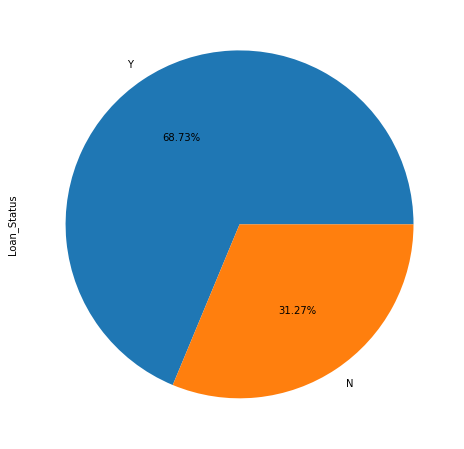

In [53]:
train['Loan_Status'].value_counts().plot(kind='pie',autopct='%.2f%%');

Podemos observar que aproximadamente 70% dos empréstimos solicitados são aprovados.

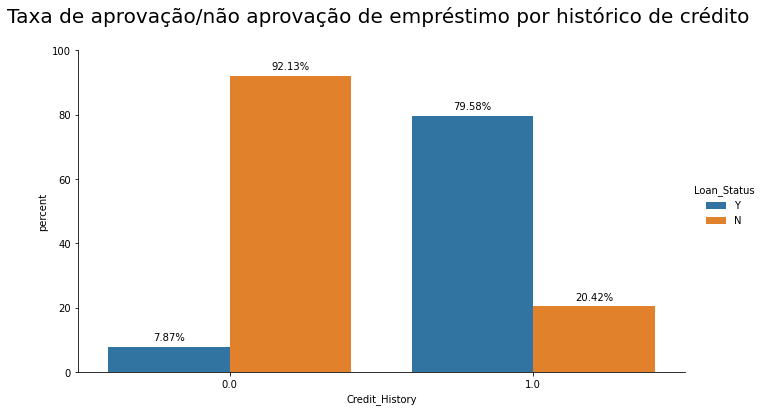

In [54]:
df1 = train.groupby('Credit_History')['Loan_Status'].value_counts(normalize=True)*100
df1 = df1.rename('percent').reset_index().sort_values(by=['percent'], ascending = True)

g = sns.catplot(x='Credit_History',y='percent',hue='Loan_Status',kind='bar',data=df1, height=5,aspect = 1.8,palette="tab10")
grafico_com_porcetagem_1(g)
plt.title('Taxa de aprovação/não aprovação de empréstimo por histórico de crédito \n', fontsize=20)
plt.show()

Podemos afirmar que os clientes com histórico de crédito positivo têm grande possibilidade de conseguir a aprovação do empréstimo solicitado, pois, a taxa de aprovação dado que eles têm  um histórico de crédito positivo,  é de aproximadamente 80%, ou seja, de 100 clientes com um histórico positivo 80 conseguem aprovação.

Por outro lado, os clientes com um histórico negativo têm poucas chances de conseguir uma aprovação, já que, aproximadamente 8% destes conseguem esse feito.


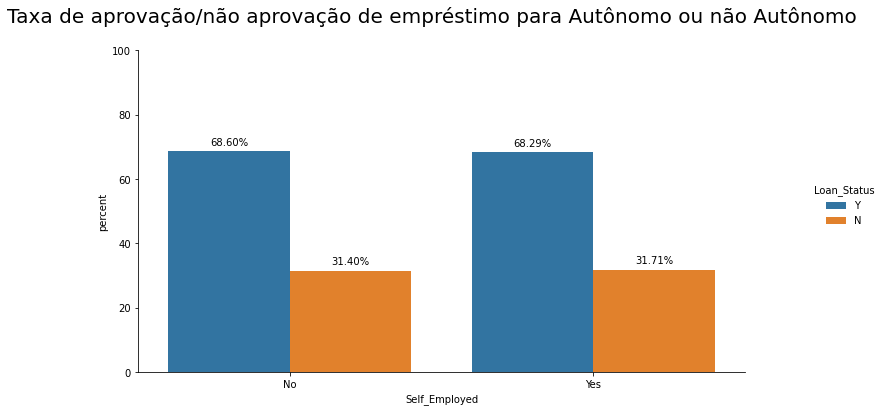

In [55]:
df2 = train.groupby('Self_Employed')['Loan_Status'].value_counts(normalize=True)*100
df2 = df2.rename('percent').reset_index()#.sort_values(by=['percent'], ascending = True)

g = sns.catplot(x='Self_Employed',y='percent',hue='Loan_Status',kind='bar',data=df2, height=5,aspect = 1.8,palette="tab10")
grafico_com_porcetagem_1(g)
plt.title('Taxa de aprovação/não aprovação de empréstimo para Autônomo ou não Autônomo   \n', fontsize=20)
plt.show()

Podemos observar que as taxas de aprovação e não aprovação de empréstimo para os clientes autónomos e não  autónomos são essencialmente as mesmas.  

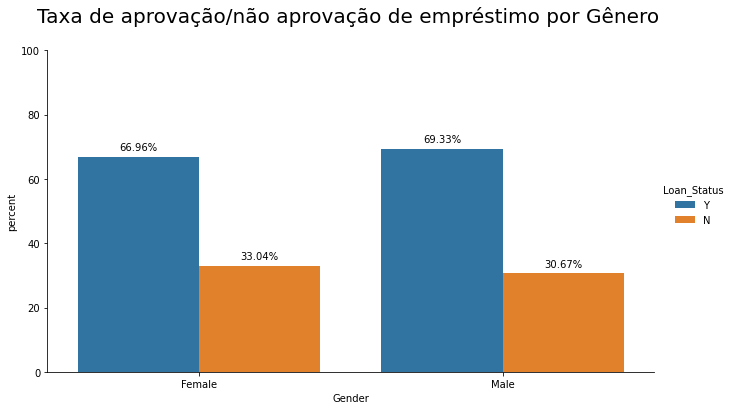

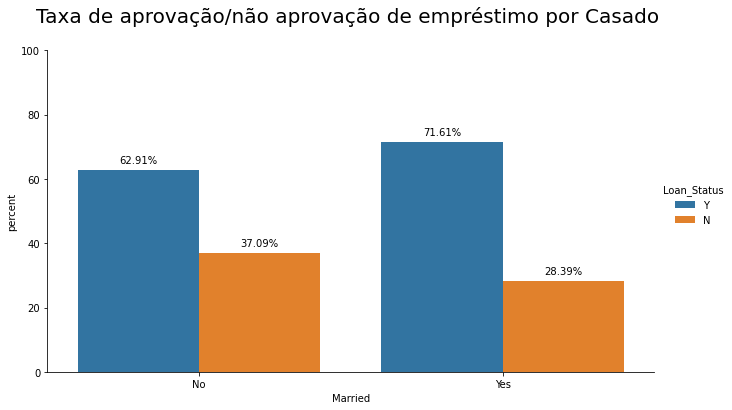

In [56]:
df3 = train.groupby('Gender')['Loan_Status'].value_counts(normalize=True)*100
df3 = df3.rename('percent').reset_index()#.sort_values(by=['percent'], ascending = True)
g3 = sns.catplot(x='Gender',y='percent',hue='Loan_Status',kind='bar',data=df3, height=5,aspect = 1.8,palette="tab10")
plt.title('Taxa de aprovação/não aprovação de empréstimo por Gênero \n', fontsize=20)
grafico_com_porcetagem_1(g3)


df4 = train.groupby('Married')['Loan_Status'].value_counts(normalize=True)*100
df4 = df4.rename('percent').reset_index()#.sort_values(by=['percent'], ascending = True)
g4 = sns.catplot(x='Married',y='percent',hue='Loan_Status',kind='bar',data=df4, height=5,aspect = 1.8,palette="tab10")
grafico_com_porcetagem_1(g4)
plt.title('Taxa de aprovação/não aprovação de empréstimo por Casado \n', fontsize=20)
plt.show()

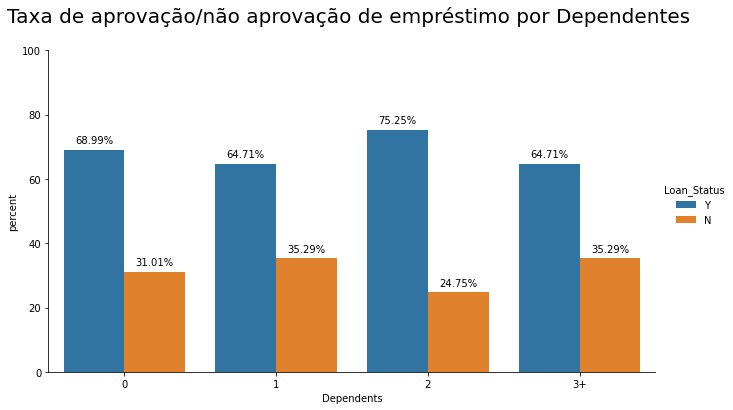

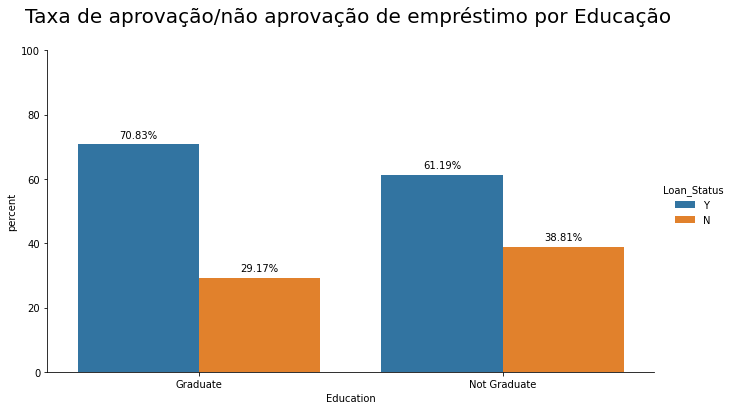

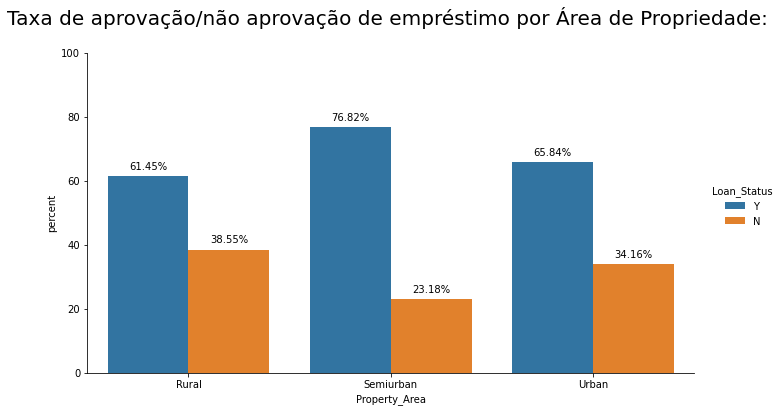

In [57]:
df5 = train.groupby('Dependents')['Loan_Status'].value_counts(normalize=True)*100
df5 = df5.rename('percent').reset_index()#.sort_values(by=['percent'], ascending = True)
g5 = sns.catplot(x='Dependents',y='percent',hue='Loan_Status',kind='bar',data=df5, height=5,aspect = 1.8,palette="tab10")
plt.title('Taxa de aprovação/não aprovação de empréstimo por Dependentes \n', fontsize=20)
grafico_com_porcetagem_1(g5)


df6 = train.groupby('Education')['Loan_Status'].value_counts(normalize=True)*100
df6 = df6.rename('percent').reset_index()#.sort_values(by=['percent'], ascending = True)
g6 = sns.catplot(x='Education',y='percent',hue='Loan_Status',kind='bar',data=df6, height=5,aspect = 1.8,palette="tab10")
grafico_com_porcetagem_1(g6)
plt.title('Taxa de aprovação/não aprovação de empréstimo por Educação \n', fontsize=20)


df7 = train.groupby('Property_Area')['Loan_Status'].value_counts(normalize=True)*100
df7 = df7.rename('percent').reset_index()#.sort_values(by=['percent'], ascending = True)
g7 = sns.catplot(x='Property_Area',y='percent',hue='Loan_Status',kind='bar',data=df7, height=5,aspect = 1.8,palette="tab10")
grafico_com_porcetagem_1(g7)
plt.title('Taxa de aprovação/não aprovação de empréstimo por Área de Propriedade: \n', fontsize=20)
plt.show()
plt.show()

### Visualizando as variáveis independentes numéricas 

* **Visualizando a variável ApplicantIncome**

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


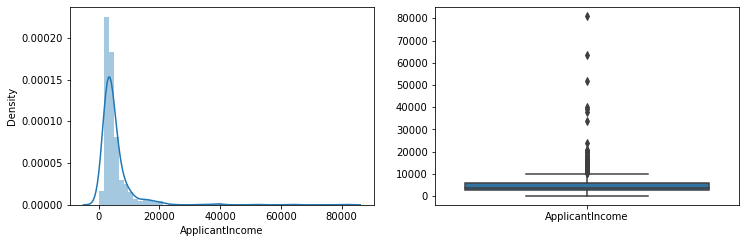

In [58]:
plt.subplot(221), sns.distplot(train['ApplicantIncome'])
plt.subplot(222), sns.boxplot(data = train.loc[:,['ApplicantIncome']]);

* **Visualizando a variável CoapplicantIncome**

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


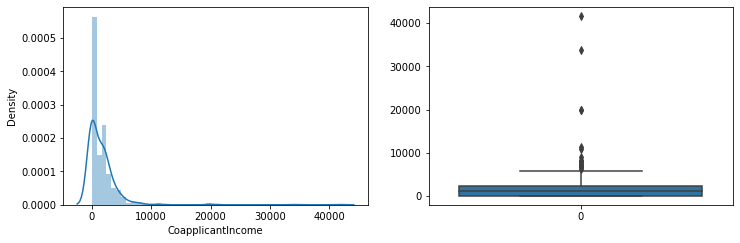

In [59]:
plt.subplot(221),sns.distplot(train['CoapplicantIncome'])
plt.subplot(222),sns.boxplot(data = train['CoapplicantIncome' ]);

* *Visualizando a variável LoanAmount*

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


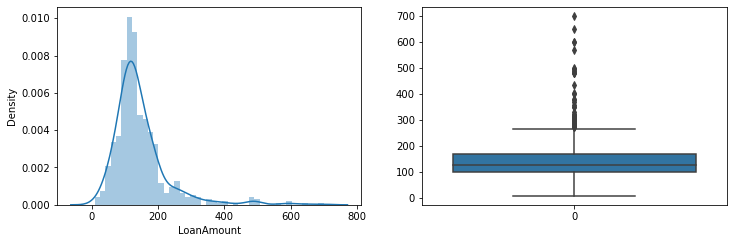

In [60]:
plt.subplot(221),sns.distplot(train['LoanAmount'].dropna())
plt.subplot(222),sns.boxplot(data = train['LoanAmount']);

## **Aplicando pré-processamento**

In [61]:
for i, df in enumerate([train, test]):
    # Preenchendo os dados ausentes das variáveis categóricas 
    df['Gender'].fillna(df['Gender'].mode()[0],inplace = True)
    df['Married'].fillna(df['Married'].mode()[0],inplace = True)
    df['Dependents'].fillna(df['Dependents'].mode()[0],inplace = True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace = True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace = True)
    # Preenchendo os dados ausentes das variáveis  numéricas
    df['LoanAmount'].fillna(df['LoanAmount'].median(),inplace = True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace = True)
    # Normalizando os valores das variáveis  LoanAmount, ApplicantIncome e CoapplicantIncome
    df['LoanAmount'] = np.log(df['LoanAmount'])
    df['ApplicantIncome'] = np.log(1 + df['ApplicantIncome'])
    df['CoapplicantIncome'] = np.log( 1+df['CoapplicantIncome'])
    # Peso nas variáveis ordinais    
    df['Dependents'].replace({'0':0,'1': 1, '2': 2, '3+':3},inplace=True)
    df['Property_Area'].replace({'Rural':0, 'Urban': 1,'Semiurban': 2},inplace=True)


* **Visualizando a variável LoanAmount normalizada**

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


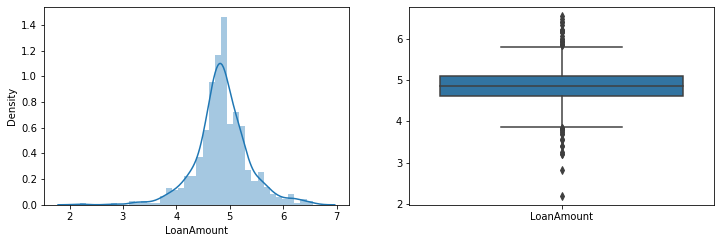

In [63]:
plt.subplot(221), sns.distplot(train['LoanAmount'])
plt.subplot(222), sns.boxplot(data = train.loc[:,['LoanAmount' ]]);

* **Visualizando a variável ApplicantIncome normalizada**  

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


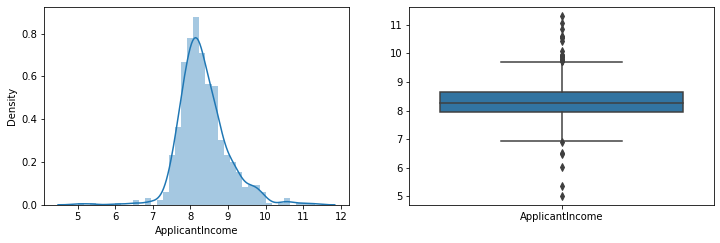

In [64]:
plt.subplot(221), sns.distplot(train['ApplicantIncome'])
plt.subplot(222), sns.boxplot(data = train.loc[:,['ApplicantIncome' ]]);


* **Visualizando a variável CoapplicantIncome normalizada**

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


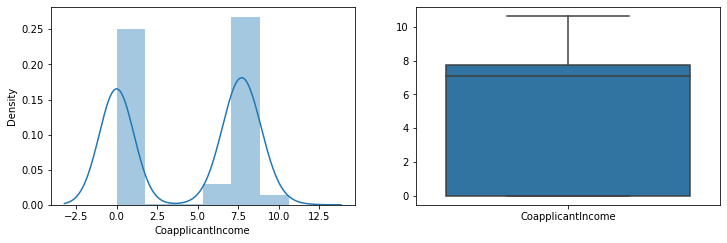

In [65]:
plt.subplot(221), sns.distplot( train['CoapplicantIncome'])
plt.subplot(222), sns.boxplot(data = train.loc[:,['CoapplicantIncome' ]]);

* **Visualizando algumas variáveis** 

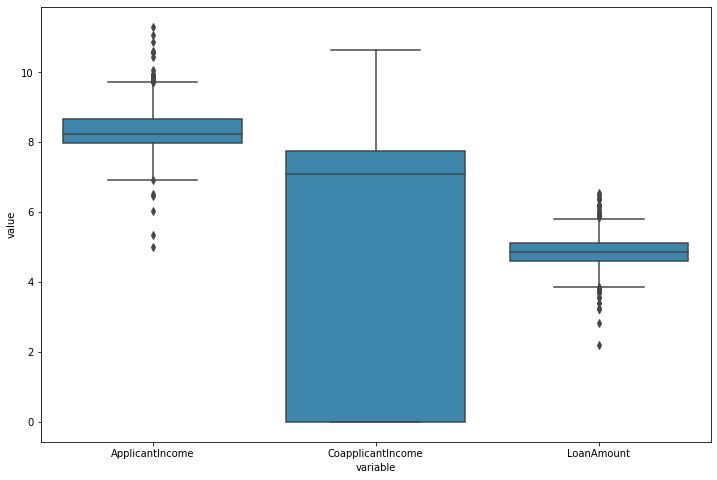

In [66]:
App = train.loc[:,['ApplicantIncome', 'CoapplicantIncome','LoanAmount']]
sns.boxplot(x = 'variable', y = 'value', data = App.melt(),color='#2b8cbe');

* **Transformando a variável resposta**

In [67]:
train['Loan_Status'].replace({'N':0,'Y':1},inplace=True)

* **Verificando as correlações entre variáveis** 

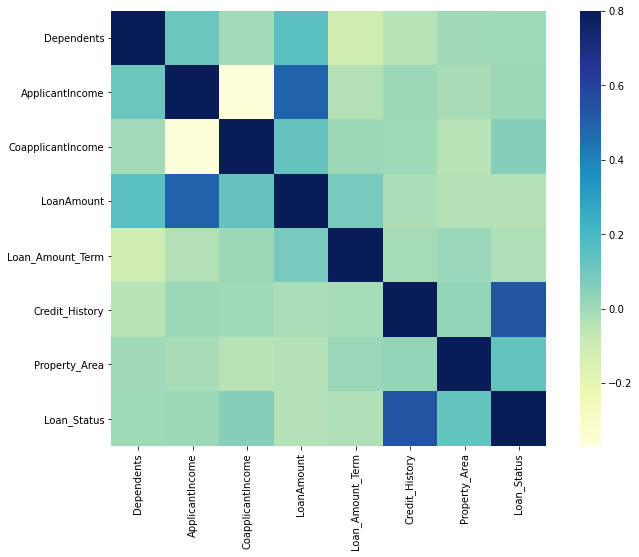

In [68]:
corr = train.corr()
sns.heatmap(corr, vmax=.8, square=True, cmap="YlGnBu");

* **Separando a variável resposta das variáveis preditoras**

In [69]:
X = train.drop(['Loan_ID','Loan_Status'], axis = 1)
y = train.Loan_Status

* **Criando variáveis fictícias para as variáveis categóricas cols = ['Gender', 'Married','Education','Self_Employed']**

In [70]:
X = pd.get_dummies(X)
test =  pd.get_dummies(test.iloc[:,1:])

* **Dividindo o conjunto de treinamento** 

In [71]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test =  train_test_split(X,y, test_size = 0.33) 

In [72]:
from lazypredict.Supervised import LazyClassifier

C:\Users\Administrador\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [73]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 24.05it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.83               0.71     0.71      0.81   
NearestCentroid                    0.79               0.71     0.71      0.78   
RandomForestClassifier             0.81               0.71     0.71      0.79   
LogisticRegression                 0.82               0.71     0.71      0.80   
BaggingClassifier                  0.77               0.71     0.71      0.77   
ExtraTreesClassifier               0.78               0.71     0.71      0.78   
LinearSVC                          0.82               0.71     0.71      0.80   
LinearDiscriminantAnalysis         0.82               0.71     0.71      0.80   
RidgeClassifierCV                  0.82               0.71     0.71      0.80   
RidgeClassifier                    0.82               0.71     0.71      0.80   
LGBMClassifier              

* **Importando o modelo de Regressão Logística**

In [74]:
from sklearn.linear_model import LogisticRegression
Reg_Log = LogisticRegression()

* **Ajustando os dados de treinamento**

In [75]:
Reg_Log.fit(X_train, y_train)

LogisticRegression()

* **Fazendo pevisão com o conjunto de dados X_test** 

In [76]:
y_pred = Reg_Log.predict(X_test)

* **Verificando quão bom é o modelo para o conjunto de dados X_test** 

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.47      0.61        58
           1       0.82      0.97      0.89       145

    accuracy                           0.83       203
   macro avg       0.85      0.72      0.75       203
weighted avg       0.83      0.83      0.81       203



* **Visualizando a matriz de confusão**

In [78]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[ 27  31]
 [  4 141]]


* **Visualizando a precisão do modelo**

In [79]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8275862068965517


* **Fazendo previsão do conjunto de dados de test**

In [82]:
test_pred = Reg_Log.predict(test)

* **Importando o arquivo de verificação de soluções**

In [83]:
submission = pd.read_csv('sample_submission.csv')

* **Inserindo a previsão do modelo do conjunto de dados  test para submissão**

In [84]:
submission['Loan_Status'] = test_pred 
submission['Loan_ID']     = test_original['Loan_ID']

* **Convertendo os valores 0 e 1 para N e Y**

In [85]:
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

* **Salvando no formato .csv para envio**

In [86]:
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('LogisticRegression.csv', index=False)

In [81]:
pd.read_csv('LogisticRegression.csv').head(10)

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
5,LP001054,Y
6,LP001055,Y
7,LP001056,N
8,LP001059,Y
9,LP001067,Y


In [87]:
pd.read_csv('LogisticRegression.csv').head(10)

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
5,LP001054,Y
6,LP001055,Y
7,LP001056,N
8,LP001059,Y
9,LP001067,Y
